Optimal epsilon_repulsive for maximum Radius of Gyration: 2.5 with Rg = 49.04889998968177
Optimal epsilon_repulsive for maximum End-to-End Distance: 2.5 with Ree = 98.02716531940843


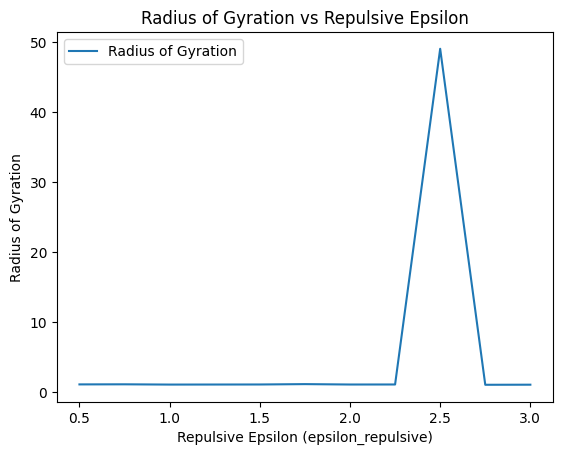

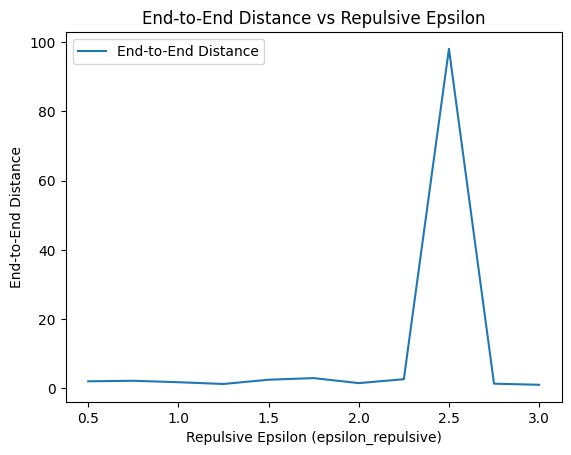

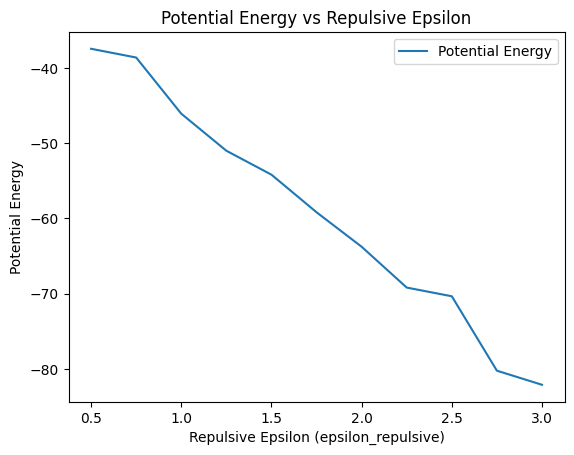

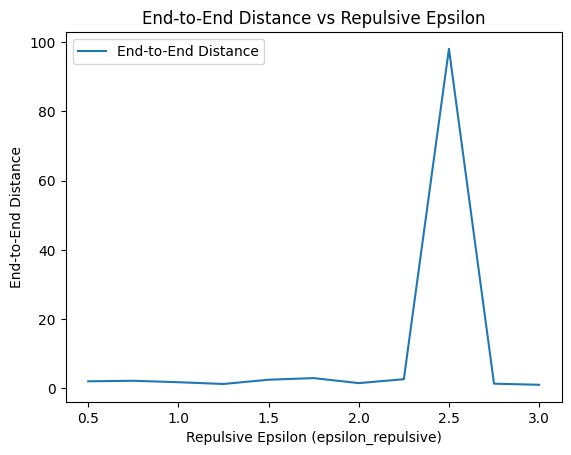

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Simulation parameters
dt = 0.01  # Time step
total_steps = 10000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 2.5 * sigma  # Cutoff for LJ interactions
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities

def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions

def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces

def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions

def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Simulation Loop
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

for step in range(total_steps):
    # Integrate equations of motion
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)
    
    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Define the range of repulsive epsilon values to evaluate
epsilon_repulsive_values = np.linspace(0.5, 3.0, 11)  # Example range of repulsive epsilon values
temperature = 0.1  # Fixed temperature
k = 1.0  # Fixed spring constant

# Arrays to store properties for each value of epsilon_repulsive
Rg_values_epsilon = []
Ree_values_epsilon = []
potential_energies_epsilon = []

# Loop through different values of epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Re-initialize positions and velocities for each value of epsilon_repulsive
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Run the simulation
    total_potential_energy = 0.0
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, temperature, mass)

        # Calculate potential energy for the current configuration
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0) ** 2

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        epsilon_value = epsilon_repulsive
                    elif abs(i - j) > 2:
                        epsilon_value = epsilon_attractive
                    else:
                        continue
                    E_LJ += 4 * epsilon_value * ((sigma / distance) ** 12 - (sigma / distance) ** 6)

        total_potential_energy = E_harmonic + E_LJ

    # Calculate Radius of Gyration and End-to-End Distance
    Rg = calculate_radius_of_gyration(positions)
    Ree = calculate_end_to_end_distance(positions)

    # Store the computed properties
    Rg_values_epsilon.append(Rg)  # Append only once
    Ree_values_epsilon.append(Ree)  # Append only once
    potential_energies_epsilon.append(total_potential_energy)


# Finding the epsilon_repulsive value that gives the maximum Rg and Ree
optimal_epsilon_index_Rg = np.argmax(Rg_values_epsilon)
optimal_epsilon_Rg = epsilon_repulsive_values[optimal_epsilon_index_Rg]
optimal_Rg = Rg_values_epsilon[optimal_epsilon_index_Rg]

optimal_epsilon_index_Ree = np.argmax(Ree_values_epsilon)
optimal_epsilon_Ree = epsilon_repulsive_values[optimal_epsilon_index_Ree]
optimal_Ree = Ree_values_epsilon[optimal_epsilon_index_Ree]

print(f"Optimal epsilon_repulsive for maximum Radius of Gyration: {optimal_epsilon_Rg} with Rg = {optimal_Rg}")
print(f"Optimal epsilon_repulsive for maximum End-to-End Distance: {optimal_epsilon_Ree} with Ree = {optimal_Ree}")

# Plotting the results for the epsilon_repulsive values
plt.figure()
plt.plot(epsilon_repulsive_values, Rg_values_epsilon, label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon')
plt.legend()
plt.show()

plt.figure()
plt.plot(epsilon_repulsive_values, Ree_values_epsilon, label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon')
plt.legend()
plt.show()

plt.figure()
plt.plot(epsilon_repulsive_values, potential_energies_epsilon, label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon')
plt.legend()
plt.show()
plt.figure()




